# Follow these instructions:

Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

## Assignment Week 8: Text Mining using Dimensionality Reduction Methods [_/100 Marks]

This dataset comes from the #TidyTuesday repository and represents 2122 TV shows. In this assignment, we will apply dimensionality reduction methods to improve our understanding of text data and to predict the number of seasons of the TV shows. 

In [1]:
!pip install umap-learn

In [2]:
import numpy as np
import pandas as pd

import umap
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA, TruncatedSVD
import sklearn.feature_extraction.text as sktext
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt
seed = 0

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alinaenikeeva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1: Decomposition of the texts [ /66 marks]

### Question 1.1

The dataset comes with the a few text variables and a categorical variable which represents whether a TV show has one season or more than one season. Import the data and create a new variable called 'full_description' by combining the three columns title, listed_in, and description. Keep the two columns,'duration' and 'full_description', and remove the rest. Do binary encoding for the traget variable 'duration'. Assign 1 to 'More than one season' and 0 to 'One season'. In the "full_description" column replace the word "Sci-Fi" with the word "Sci_Fi" since we would want to treat "Sci-Fi" as single word. Select the full_description column and display its first 10 rows. Use sklearn's `TfidfVectorizer` to eliminate accents, special characters, and stopwords (please see below to find out what stopwords need to be removed). In addition, make sure to eliminate words that appear in less than 5% of documents and those that appear in over 95%. You can also set `sublinear_tf` to `True`. After that, split the data into train and test with `test_size = 0.2` and `seed = seed`. Calculate the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) for both train and test. Note that you need to fit and transform the inputs for the train set but you only need to transform the inputs for the test set. Don't forget to turn the sparse matrices to dense ones after you apply the `Tf-Idf` transform.  

In [3]:
Data=pd.read_csv("Netflix_data.csv")
Data.head()



,Unnamed: 0,country,month,year_2021_release,rating,duration,listed_in,description
0,3%,Country-other,August,1,TV-MA,More than one season,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,46,Country-other,July,5,TV-MA,One season,"International TV Shows, TV Dramas, TV Mysteries",A genetics professor experiments with a treatm...
2,1983,Country-other,November,3,TV-MA,One season,"Crime TV Shows, International TV Shows, TV Dramas","In this dark alt-history thriller, a naïve law..."
3,1994,Country-other,May,2,TV-MA,One season,"Crime TV Shows, Docuseries, International TV S...",Archival video and new interviews examine Mexi...
4,​SAINT SEIYA: Knights of the Zodiac,Japan,January,1,TV-14,More than one season,"Anime Series, International TV Shows",Seiya and the Knights of the Zodiac rise again...


In [4]:
Data['full_description'] = Data['Unnamed: 0'] + ' ' + Data['listed_in'] + ' ' + Data['description']
Data = Data[['duration', 'full_description']]
Data.head()

,duration,full_description
0,More than one season,"3% International TV Shows, TV Dramas, TV Sci-F..."
1,One season,"46 International TV Shows, TV Dramas, TV Myste..."
2,One season,"1983 Crime TV Shows, International TV Shows, T..."
3,One season,"1994 Crime TV Shows, Docuseries, International..."
4,More than one season,​SAINT SEIYA: Knights of the Zodiac Anime Seri...


In [5]:
pip install --upgrade category_encoders

Note: you may need to restart the kernel to use updated packages.


In [6]:
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=['duration'])
dfbin = encoder.fit_transform(Data['duration'])
df = pd.concat([Data,dfbin], axis =1)
df = df[['full_description','duration_1']]
df.head()

,full_description,duration_1
0,"3% International TV Shows, TV Dramas, TV Sci-F...",1
1,"46 International TV Shows, TV Dramas, TV Myste...",0
2,"1983 Crime TV Shows, International TV Shows, T...",0
3,"1994 Crime TV Shows, Docuseries, International...",0
4,​SAINT SEIYA: Knights of the Zodiac Anime Seri...,1


In [7]:
df.loc[:, 'full_description'] = df['full_description'].str.replace('Sci-Fi', 'Sci_Fi')
print(df.loc[:9, 'full_description'])

0    3% International TV Shows, TV Dramas, TV Sci_F...
1    46 International TV Shows, TV Dramas, TV Myste...
2    1983 Crime TV Shows, International TV Shows, T...
3    1994 Crime TV Shows, Docuseries, International...
4    ​SAINT SEIYA: Knights of the Zodiac Anime Seri...
5    (Un)Well Reality TV This docuseries takes a de...
6    #blackAF TV Comedies Kenya Barris and his fami...
7    Şubat Crime TV Shows, International TV Shows, ...
8    100 Days My Prince International TV Shows, Rom...
9    100 Humans Docuseries, Science & Nature TV One...
Name: full_description, dtype: object


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = ENGLISH_STOP_WORDS.union(['shows', 'tv'])
tfidf = sktext.TfidfVectorizer(strip_accents='unicode', stop_words=stop_words, sublinear_tf=True, min_df=0.05, max_df=0.95)


In [9]:
# Defining the TfIDFTransformer [ /4 marks]
# Define a vectors of stop words: stop words list must contain 'english' stop words, 'shows', and 'tv' 

seed = seed
train_data, test_data = train_test_split(df, test_size=0.2, random_state=seed)

TfIDF_train = tfidf.fit_transform(train_data['full_description'])
TfIDF_test = tfidf.transform(test_data['full_description'])

# Convert sparse matrices to dense ones
train_tfidf_dense = TfIDF_train.todense()
test_tfidf_dense = TfIDF_test.todense()

y_test = test_data.copy()
y_train = train_data.copy()

From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required). Print the number of indices in the ouput using [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [10]:
# Print the number of indices [ /2 marks]
print(len(tfidf.get_feature_names()))

24


/Users/alinaenikeeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Question 1.2
Now we have the TfIDF matrix so we can start working on the data. We hope to explore what some commonly occuring concepts are in the 'full_description' column. We can do this using PCA. A PCA transform of the TF-IDF matrix will give us a basis of the text data, each component representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic. Calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts.

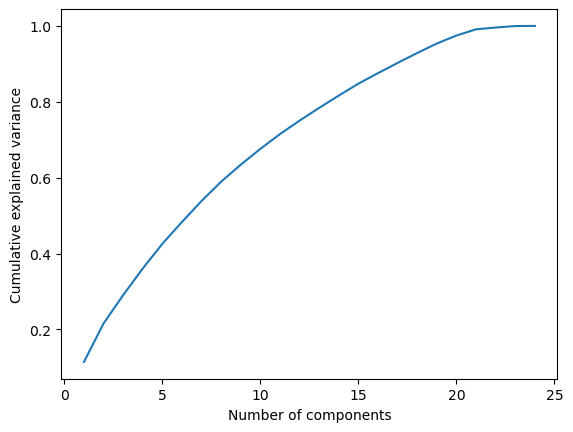

In [11]:
# Apply PCA on training data and get the explained variance [ / 4 marks]
pca = PCA(n_components=TfIDF_train.shape[1], random_state=seed)
pca.fit(TfIDF_train.toarray())

# Plot the explained variance per number of components
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()
# Plotting explained variance with number of concepts [ / 4 marks]


**Question:** Exactly how many concepts do we need to correctly explain at least 80% of the data?


In [12]:
# To get the exact index where the variance is above 80% [ / 4 marks]
num_concepts = np.argmax(cumulative_variance >= 0.8) + 1

print("Number of concepts to explain at least 80% of the data:", num_concepts)

Number of concepts to explain at least 80% of the data: 14


**Your Answer:** 

### Question 1.3

Let's examine the first three concepts by looking how many variance they explained and showing the 10 words that are the most important in each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).


In [13]:
from sklearn.decomposition import PCA
pca = PCA()

pca.fit(TfIDF_train.toarray())

explained_variance = pca.explained_variance_ratio_

pca_weights = pca.components_[:3]
feature_names = tfidf.get_feature_names()

for i in range(3):
    
    top_word_indices = np.argsort(np.abs(pca_weights[i]))[::-1][:10]
    top_words = [feature_names[index] for index in top_word_indices]

    print("Concept", i+1, "explained variance:", explained_variance[i])
    print("Top 10 words:", top_words)

Concept 1 explained variance: 0.11438778789279472
Top 10 words: ['dramas', 'kids', 'international', 'crime', 'docuseries', 'series', 'romantic', 'reality', 'comedies', 'world']
Concept 2 explained variance: 0.10130206760920192
Top 10 words: ['docuseries', 'comedies', 'kids', 'crime', 'british', 'reality', 'series', 'dramas', 'romantic', 'friends']
Concept 3 explained variance: 0.07479703840999602
Top 10 words: ['reality', 'kids', 'crime', 'romantic', 'dramas', 'international', 'comedies', 'love', 'docuseries', 'korean']


/Users/alinaenikeeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Question 1.4

 Apply the PCA transformation to the test dataset. Use only the first two components and make a scatter plot of the TV shows. Identify the 'More than one season' TV shows, and 'One season' TV shows by colouring points with different colours. Make sure to add a legend to your plot!

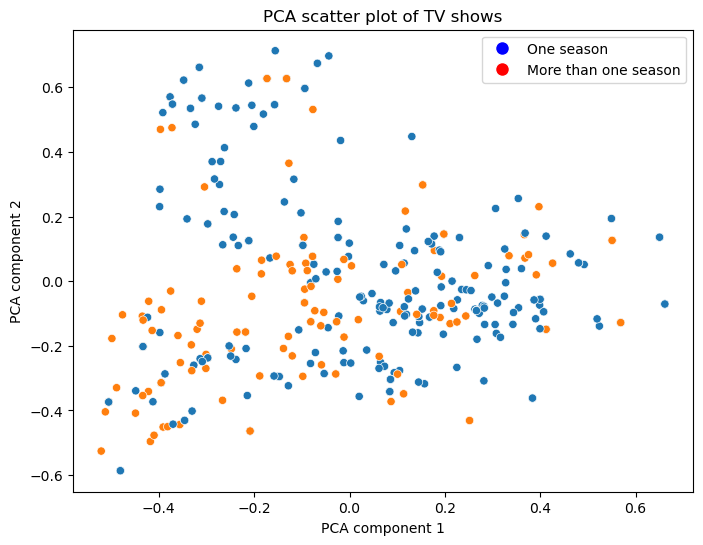

In [14]:
TfIDF_test = tfidf.transform(test_data['full_description'])


pca_test = pca.transform(TfIDF_test.toarray())
pca_test = pca_test[:, :2]


plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_test[:, 0], y=pca_test[:, 1], hue=test_data['duration_1'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('PCA scatter plot of TV shows')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='One season', markerfacecolor='blue', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='More than one season', markerfacecolor='red', markersize=10)])
plt.show()

**Question:** What can we say about where 'More than one season' TV shows and 'One season' TV shows lie in our plot? Could we use these concepts to discriminate these cases? If yes, why? If no, why not? Discuss your findings. [ /2 marks]
 
**Your answer:** 
We can see that one season tv shows are mostly represented at the left top corner while tv shows with more than one season on the bottom, however the significant amount of them is overlapping in the middle of the scatterplot.
So this 2 PCA components might help discriminate between the 2 classes but it defenetly will not be enough for accurate classification.

### Question  1.5

Repeat the process above, only now using a UMAP projection with two components. Test all combinations of ```n_neighbors=[2, 10, 25, 35, 45]``` and ```min_dist=[0.1, 0.25, 0.5, 1]``` over the train data and choose the projection that you think is best, and apply it over the test data. Use 1000 epochs, a cosine metric and random initialization. If you have more than 8GB of RAM (as in Colab), you may want to set ```low_memory=False``` to speed up computations.

*Hint: [This link](https://stackoverflow.com/questions/16384109/iterate-over-all-combinations-of-values-in-multiple-lists-in-python) may be helpful.*



/Users/alinaenikeeva/opt/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


n_neighbors: 2, min_dist: 0.1 


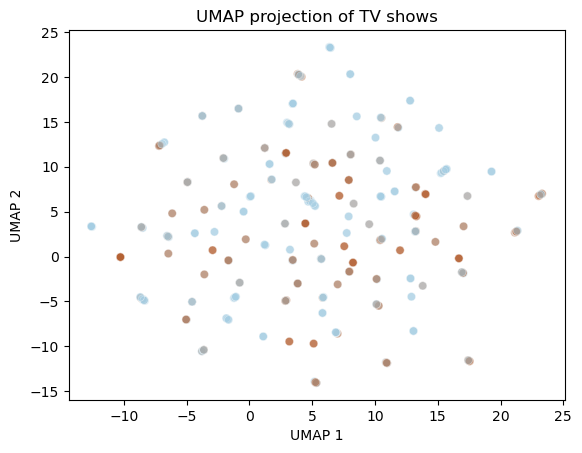

/Users/alinaenikeeva/opt/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


n_neighbors: 2, min_dist: 0.25 


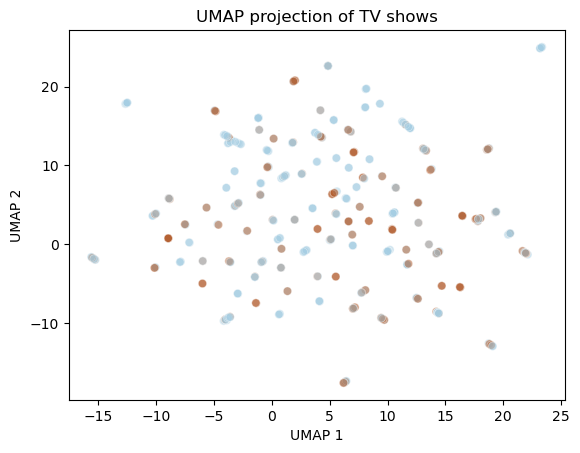

/Users/alinaenikeeva/opt/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


n_neighbors: 2, min_dist: 0.5 


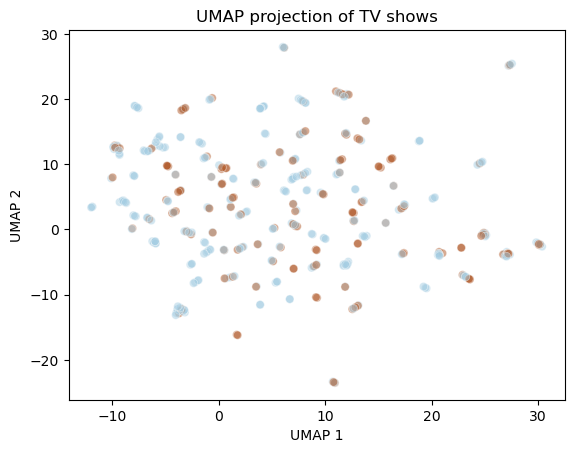

n_neighbors: 2, min_dist: 1 


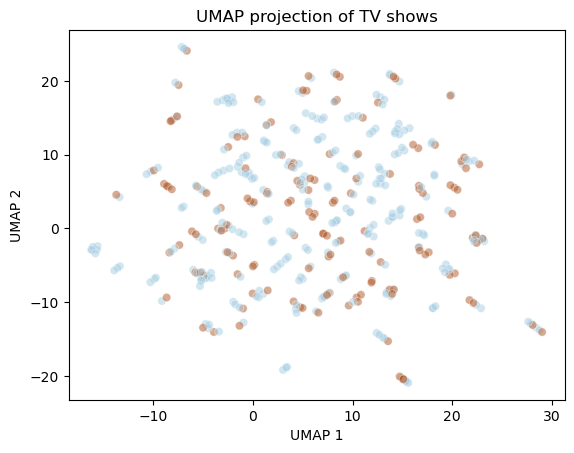

n_neighbors: 10, min_dist: 0.1 


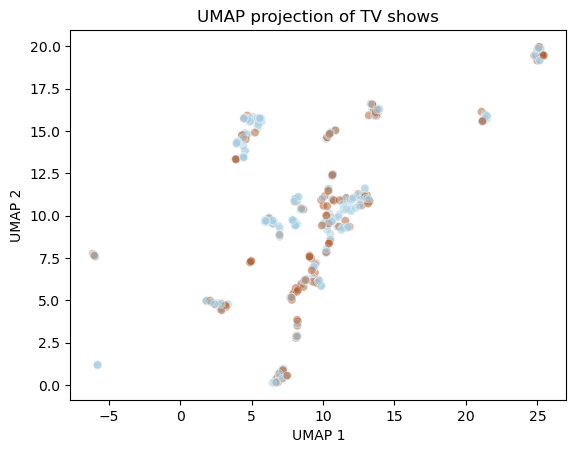

n_neighbors: 10, min_dist: 0.25 


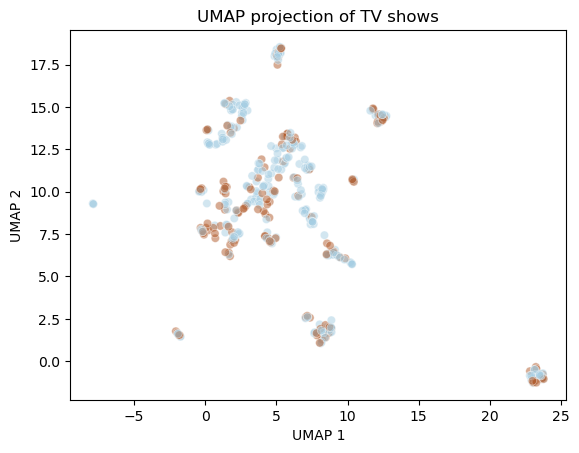

n_neighbors: 10, min_dist: 0.5 


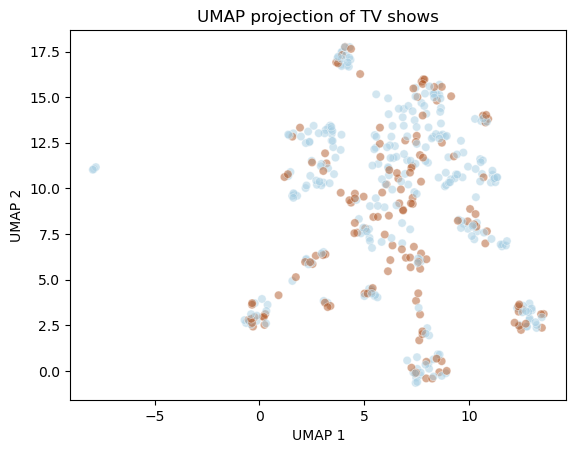

n_neighbors: 10, min_dist: 1 


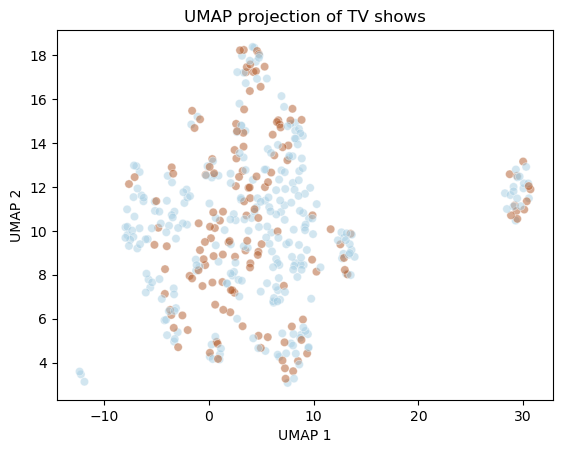

n_neighbors: 25, min_dist: 0.1 


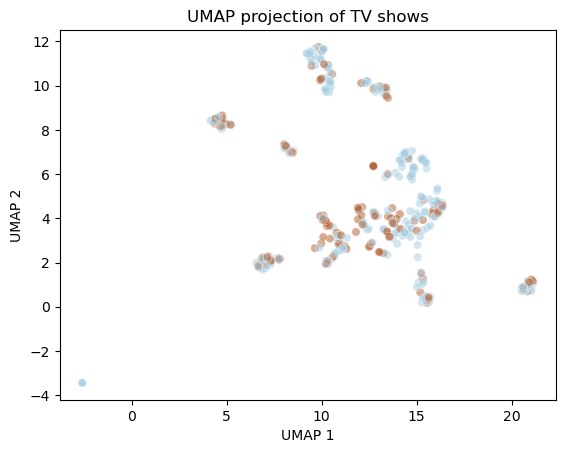

n_neighbors: 25, min_dist: 0.25 


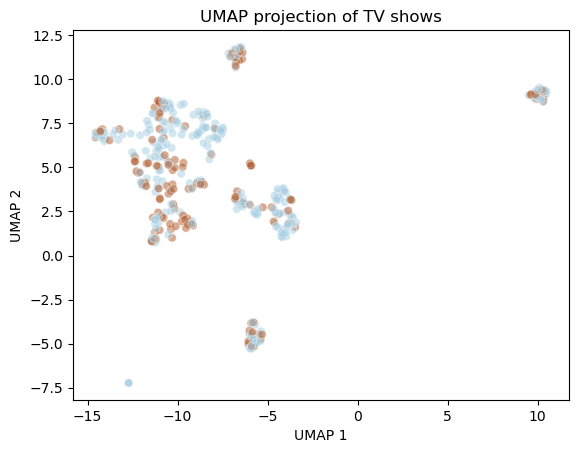

n_neighbors: 25, min_dist: 0.5 


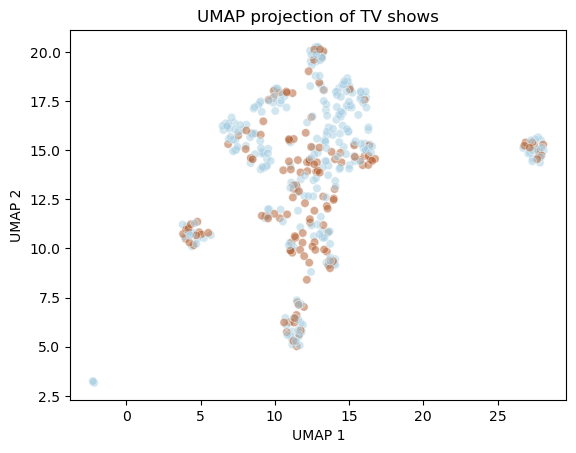

n_neighbors: 25, min_dist: 1 


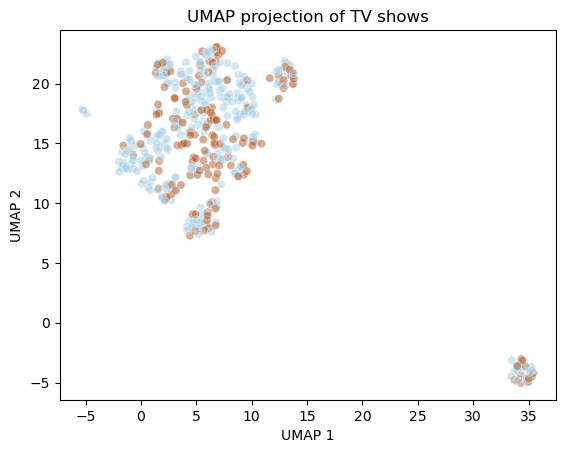

n_neighbors: 35, min_dist: 0.1 


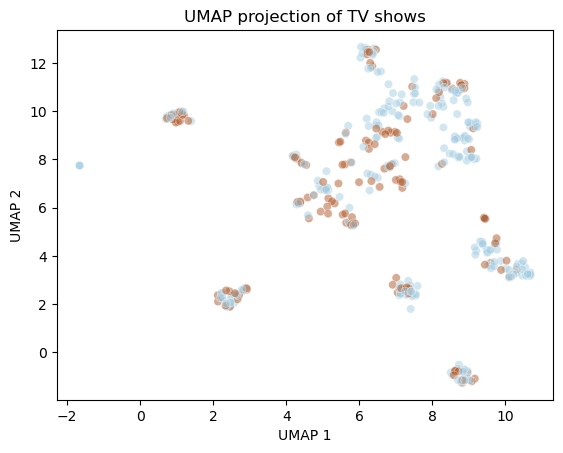

n_neighbors: 35, min_dist: 0.25 


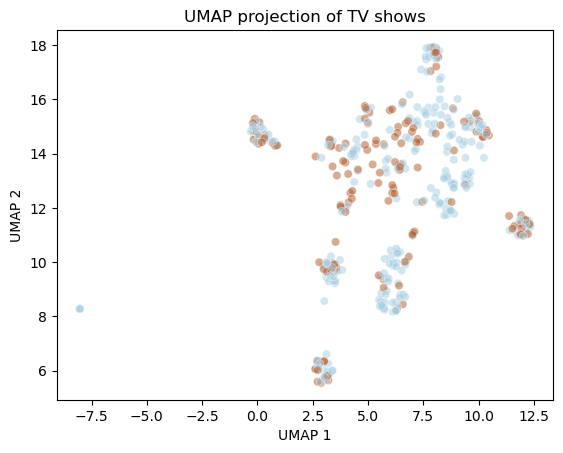

n_neighbors: 35, min_dist: 0.5 


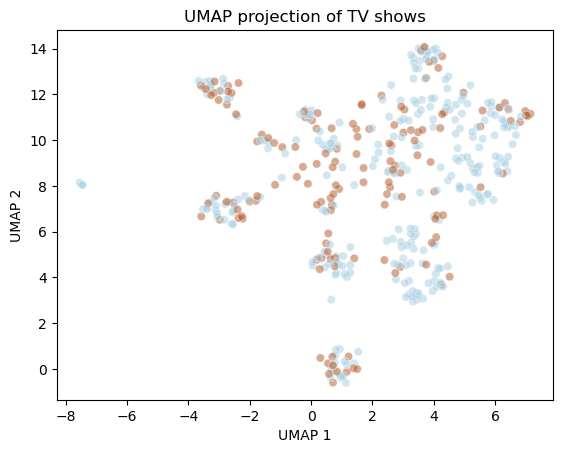

n_neighbors: 35, min_dist: 1 


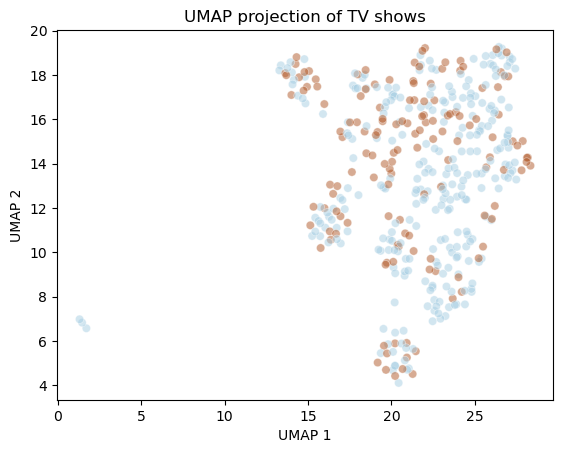

n_neighbors: 45, min_dist: 0.1 


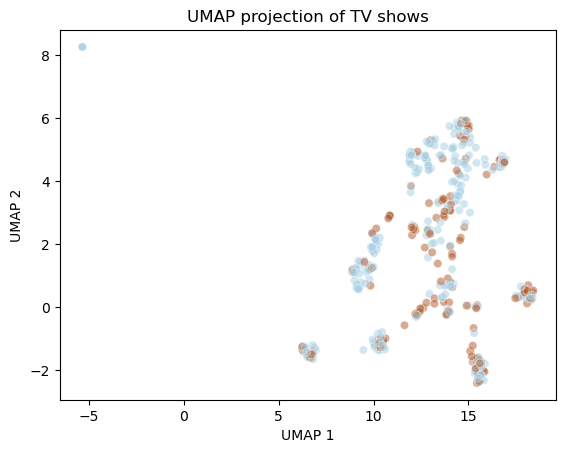

n_neighbors: 45, min_dist: 0.25 


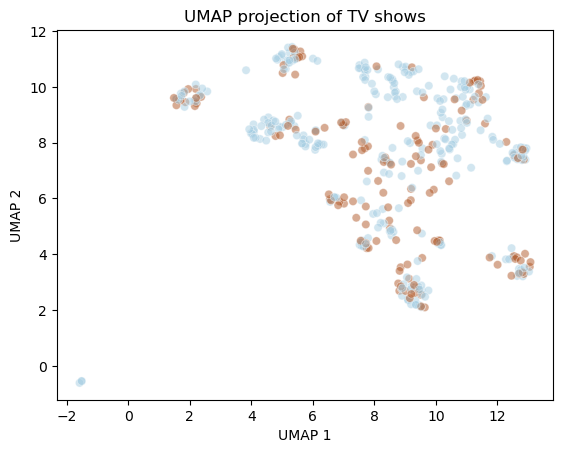

n_neighbors: 45, min_dist: 0.5 


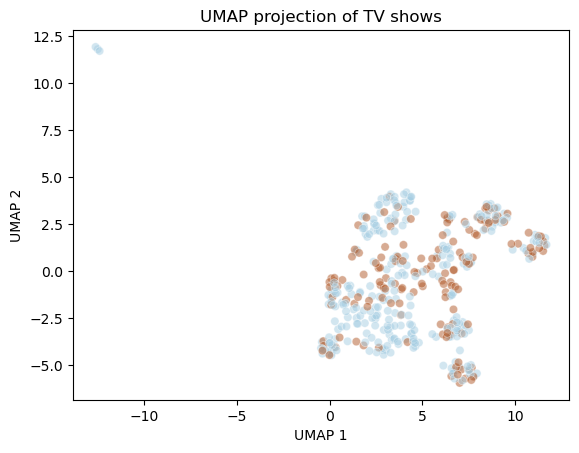

n_neighbors: 45, min_dist: 1 


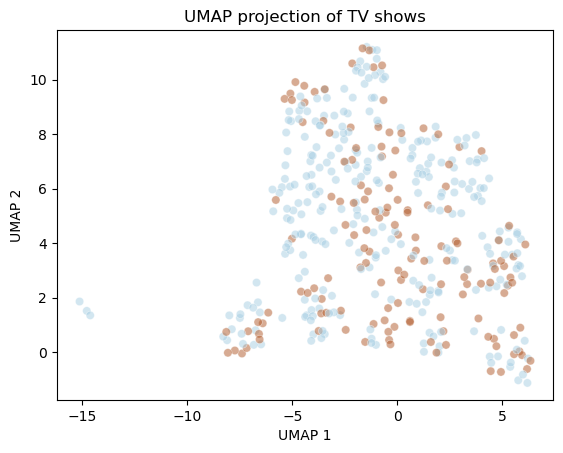

In [15]:
import umap.umap_ as umap
import matplotlib.pyplot as plt


n_neighbors = [2, 10, 25, 35, 45]
min_dist = [0.1, 0.25, 0.5, 1]

for n in n_neighbors:
    for md in min_dist:
        reducer = umap.UMAP(n_components=2, n_neighbors=n, min_dist=md, metric='hellinger', random_state=42)
        embedding = reducer.fit_transform(TfIDF_test.toarray())

        print(f"n_neighbors: {n}, min_dist: {md} ")
        sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], c=y_test['duration_1'], cmap='Paired', alpha=0.5)
        plt.title("UMAP projection of TV shows")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.show()


**Question:** Which paramter would you choose? [ / 2 marks]

**Your Answer:** 

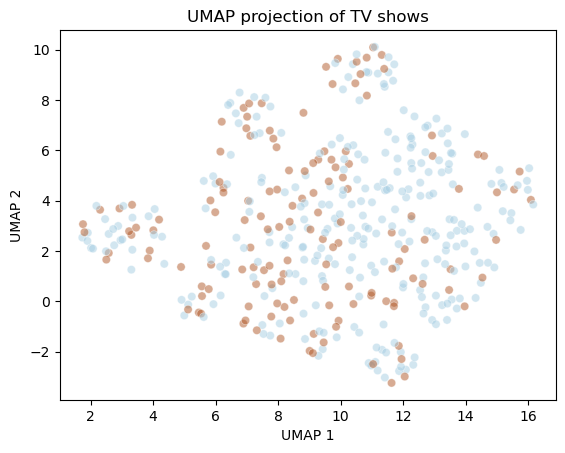

In [16]:
# Choose the paramters that you think are best and apply to test set [ / 4 marks]

# n_neighbors: 45, min_dist: 1 
# Create plot [ /2 marks]
reducer = umap.UMAP(n_components=2, n_neighbors=45, min_dist=1, metric='cosine', random_state=42)
embedding = reducer.fit_transform(TfIDF_test.toarray())
sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], c=y_test['duration_1'], cmap='Paired', alpha=0.5)
plt.title("UMAP projection of TV shows")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


**Question:** How does the plot compare to the PCA one? [ /2 marks]

**Your answer:** 
2 classes are less overlaping in the middle, more one season shows on the right and more than one season shows on the left. Provides better discrimination of the cases than PCA.

## Task 2: Benchmarking predictive capabilities of the compressed data [ / 34 marks]

For this task, we will benchmark the predictive capabilities of the compressed data against the original one. 



### Question 2.1 
Train a regularized logistic regression over the original TfIDF train set using l2 regularization. Calculate the AUC score and plot the ROC curve for the original test set.

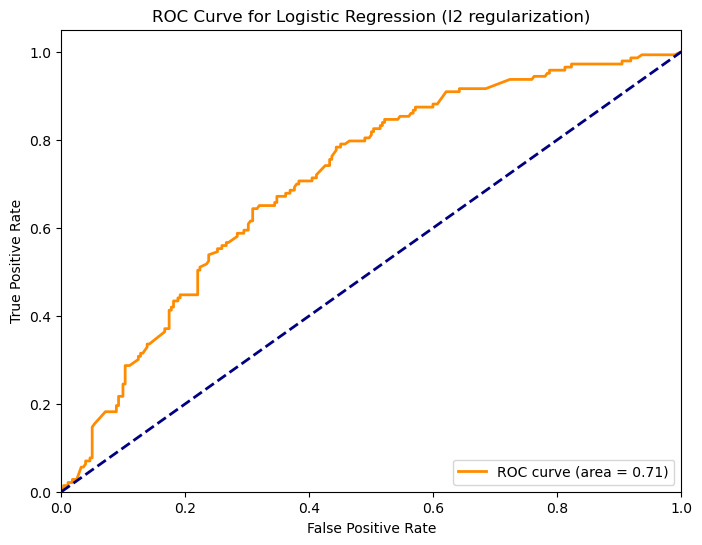

In [17]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, auc

# Define the model
lr_cv = LogisticRegressionCV(penalty='l2', max_iter=1000)

# Fit on the training dataset
lr_cv.fit(TfIDF_train, y_train['duration_1'])

# Apply to the test dataset
y_pred = lr_cv.predict_proba(TfIDF_test)[:, 1]

# Plot ROC curve and compute AUC score
fpr, tpr, thresholds = roc_curve(y_test['duration_1'], y_pred)
roc_auc = auc(fpr, tpr)

# Create and show the plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression (l2 regularization)')
plt.legend(loc="lower right")
plt.show()


### Question 2.2 
Train a regularized logistic regression over an SVD-reduced dataset (with 13 components) using l2 regularization. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set.

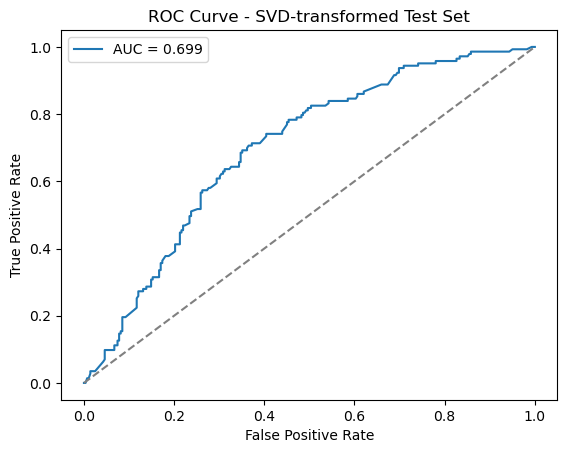

In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, auc

# Apply SVD to the train and test sets
svd = TruncatedSVD(n_components=13, random_state=42)
svd.fit(TfIDF_train)
TfIDF_train_svd = svd.transform(TfIDF_train)
TfIDF_test_svd = svd.transform(TfIDF_test)

# Train a logistic regression model with L2 regularization
lr = LogisticRegressionCV(Cs=10, cv=5, penalty='l2', solver='liblinear', random_state=42)
lr.fit(TfIDF_train_svd, y_train['duration_1'])

# Test the model on the transformed test set
y_pred = lr.predict_proba(TfIDF_test_svd)[:, 1]

# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test['duration_1'], y_pred)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"AUC = {round(auc_score, 3)}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVD-transformed Test Set')
plt.legend()
plt.show()

### Question 2.3 
Train a regularized logistic regression over the UMAP-reduced dataset (with 13 components using the same parameters as Task 1.5) using l2 regularization. Calculate the AUC score and plot the ROC curve for the UMAP-transformed test set.

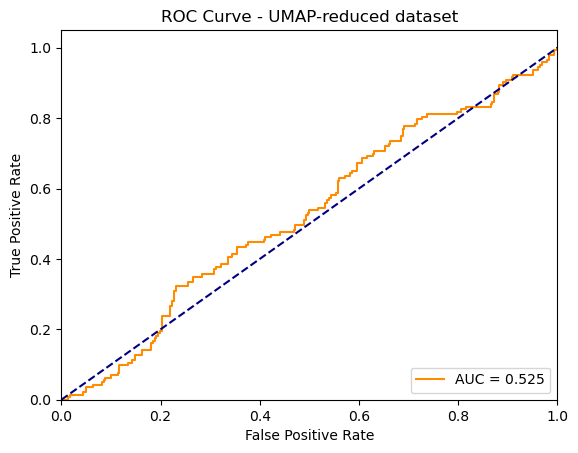

In [19]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve

# Apply UMAP to the train set
umap_transformer = umap.UMAP(n_components=13, n_neighbors=25, min_dist=0.5, metric='cosine', random_state=42)
umap_train = umap_transformer.fit_transform(TfIDF_train)

# Apply UMAP to the test set
umap_test = umap_transformer.transform(TfIDF_test)

# Define the model
model = LogisticRegressionCV(cv=5, penalty='l2', max_iter=5000, random_state=42)

# Fit on the training dataset
model.fit(umap_train, y_train['duration_1'])

# Apply to the test dataset
y_pred = model.predict_proba(umap_test)[:, 1]

# Plot ROC curve and compute AUC score
fpr, tpr, thresholds = roc_curve(y_test['duration_1'], y_pred)
auc_score = roc_auc_score(y_test['duration_1'], y_pred)

# Calculate the ROC curve points
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - UMAP-reduced dataset')
plt.legend(loc="lower right")
plt.show()

### Question 2.4
Train a XGBoost model over the SVD-reduced dataset prepared in Question 2.2. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set. In your model set ``num_boost_round=10`` and ``early_stopping_rounds=2``. You need to do CV using the training dataset, and then get best iteration based on cross-validation results. Finally, train the model on full training dataset with best number of iterations.

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

# Define XGBoost parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 3,
}
from sklearn.decomposition import TruncatedSVD

# Apply SVD to the training data
svd = TruncatedSVD(n_components=13, random_state=42)
train_svd = svd.fit_transform(train_tfidf_dense)

# Define cross-validation object
xgb_cv = GridSearchCV(XGBClassifier(**params, n_estimators=10, early_stopping_rounds=2), 
                      {"learning_rate": [0.01, 0.1, 1]}, 
                      cv=3,
                      n_jobs=-1,
                      scoring="roc_auc")

# Perform cross-validation with XGBoost
xgb_cv.fit(TfIDF_train_svd, y_train['duration_1'])

# Get best iteration based on cross-validation results
best_num_boost_rounds = xgb_cv.best_estimator_.get_booster().best_ntree_limit

# Train final model on full dataset with best number of iterations
xgb_model = XGBClassifier(**params, n_estimators=best_num_boost_rounds, early_stopping_rounds=2)
xgb_model.fit(TfIDF_train_svd, y_train['duration_1'])

# Compute predicted probabilities on the test set
test_pred_proba = xgb_model.predict_proba(y_test)[:, 1]

# Plot ROC curve and compute AUC score
fpr, tpr, thresholds = roc_curve(y_test['duration_1'], test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()


/Users/alinaenikeeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/alinaenikeeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alinaenikeeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680,

AssertionError: Must have at least 1 validation dataset for early stopping.

### Question 2.5
Compare the performance of the four models. Which one is the best. [ / 2 marks] 

**Your Answer:** 